This jupyter-notebook has be created with 'jupytext'.

Use this [Link](https://colab.research.google.com/github/magnumnp/magnumnp_demos/blob/main/softmagnetic_composite.ipynb) to directly open the Notebook in Google Colab.

## Install magnum.np and fetch reference data (required for Colab)

In [1]:
!pip install -q triton magnumnp
from os import path
if not path.isdir("ref"):
    !mkdir ref
    !wget -P ref https://gitlab.com/magnum.np/magnum.np/raw/main/demos/softmagnetic_composite/ref/m.dat &> /dev/null

# Softmagnetic Composite Demo

## Run Simulation

In [2]:
from magnumnp import *
import torch
import pathlib
from tqdm import tqdm

#SIZE_CUBE = 900e-9
#gap = 23.08 14.29 9.09 6.98 4.35
#Ni = 13 21 33 43 69
#N = 3*Ni + 1 = 40 64 100 130 208

N = 40
set_log_level(25) # show info_green, but hide info_blue
Timer.enable()
try:
    this_dir = pathlib.Path(__file__).resolve().parent
except:
    this_dir = pathlib.Path().resolve()

# initialize state
dt = 1e-10
Nx, Ny, Nz = 3, 3, 3
nx, ny, nz = N, N, N
dx, dy, dz = 900e-9 / (N-1), 900e-9 / (N-1), 900e-9 / (N-1)

mesh = Mesh((nx,ny,nz), (dx,dy,dz), pbc = (1,1,1))
state = State(mesh)
state.m = state.Constant([0,0,1])
state.material = {"alpha": 1.0}

state.material["Ms"] = state.Constant([0.0001/constants.mu_0])
state.material["Ms"][nx%Nx:,ny%Ny:,nz%Nz:] = 1.5/constants.mu_0

state.material["A"] = state.Constant([0.])
state.material["A"][nx%Nx:,ny%Ny:,nz%Nz:] = 10e-12

state.material["Ku"] = state.Constant([0.])
state.material["Ku"][nx%Nx:,ny%Ny:,nz%Nz:] = 8e3

k_dir = torch.tensor(((1.688281290426342229e-01, -7.18775080428410873e-01, 6.744326850020654351e-01),
                      (-1.24488794472133734e-02, 8.827421556265807601e-01, 4.696927847862328309e-01),
                      (4.360199027887372986e-02, 9.960452028850761419e-01, -7.74133079860866157e-02),
                      (3.749512630383480816e-01, 6.881354883832631053e-01, -6.21193287128471327e-01),
                      (8.860065554198717219e-01, 2.300892602270045995e-01, -4.02555978816864223e-01),
                      (-7.89116308031293234e-02, -7.44290764462179010e-01, -6.63177361239280949e-01),
                      (1.534426618908853179e-01, 6.661409155280296757e-01, 7.298709681658244186e-01),
                      (3.629777351625293469e-02, 7.384491837339980380e-01, 6.733314745950575997e-01),
                      (-6.22338299750334056e-01, -4.54495719851937984e-01, -6.37282261874698607e-01),
                      (5.091810893444697061e-01, -7.86185846048253700e-01, 3.502091285608797122e-01),
                      (-7.42309465286212555e-01, 5.245654409560085440e-01, 4.169025736321682052e-01),
                      (2.976579786344664136e-01, 5.698206235530806074e-01, -7.65966177274703174e-01),
                      (6.783747177775549531e-02, -5.13898942407917780e-01, 8.551642850440059895e-01),
                      (-4.09811740153190107e-01, -6.51000036118079772e-01, -6.38947017057653221e-01),
                      (-4.35391566957816666e-01, 7.000228998401875069e-01, -5.66040743340399221e-01),
                      (-3.67275369838029608e-01, -9.06849357668608080e-01, -2.06719726214920074e-01),
                      (-7.24876157150795674e-01, 2.752762585295002173e-01, -6.31488351661607993e-01),
                      (7.999944917638109887e-01, -5.94809366836661745e-01, -7.88075521186358679e-02),
                      (-6.38660840611896762e-01, -7.30613237722315789e-01, -2.41488359002706959e-01),
                      (5.978837032381554284e-01, -9.09378167932159697e-02, 7.964078043810925989e-01),
                      (-9.29805720633694821e-01, -3.57570345696486047e-01, 8.720533100304592167e-02),
                      (4.682836169203208332e-01, -6.07627185281937154e-01, -6.41482390896564447e-01),
                      (7.309975652323822404e-01, 1.317784064962062851e-01, -6.69534921572915164e-01),
                      (-1.26449163913964823e-01, -9.90975538690972102e-01, -4.44757311530326326e-02),
                      (4.076648517742982869e-01, 5.753823407754260488e-01, 7.090448015123099745e-01),
                      (3.803260297965609382e-01, 9.217214425940288836e-01, 7.603744683751342825e-02),
                      (-7.25468075571367832e-01, 2.563257490022778362e-01, -6.38743439672923241e-01))).reshape(3,3,3,3)
k_dir = k_dir.repeat_interleave(nx//Nx,0).repeat_interleave(ny//Ny,1).repeat_interleave(nz//Nz,2)

state.material["Ku_axis"] = state.Constant([1,1,1])
state.material["Ku_axis"][nx%Nx:,ny%Ny:,nz%Nz:,:] = k_dir

write_vti(state.material, "data/material.vti", state)

# initialize field terms
demag    = DemagFieldPBC()
exchange = ExchangeField()
aniso    = UniaxialAnisotropyField()
external = ExternalField(TimeInterpolator(state, {0.0e-9: [0.0, 0.0, 0.0],
                                                  1.0e-9: [0.0, 0.0, 0.0],
                                                  3.5e-9: [0.1/constants.mu_0, 0.0, 0.0],
                                                  8.5e-9: [-0.1/constants.mu_0, 0.0, 0.0],
                                                 13.5e-9: [0.1/constants.mu_0, 0.0, 0.0]}))

# perform integration
llg = LLGSolver([demag, exchange, aniso, external])
logger = ScalarLogger(this_dir / "data" / "m.dat", ['t', external.h, 'm'])

for i in tqdm(torch.arange(0, 13.5e-9, dt)):
    llg.step(state, dt)
    logger << state

Timer.print_report()

2024-11-08 10:19:30  magnum.np:INFO magnum.np 2.0.1


2024-11-08 10:19:30  magnum.np:INFO [State] running on device: cpu (dtype = float64)


2024-11-08 10:19:30  magnum.np:INFO [Mesh] 40x40x40 (dx= 2.30769e-08 x 2.30769e-08 x 2.30769e-08, pbc=[1,1,1])


2024-11-08 10:19:30  magnum.np:INFO [LLGSolver] using RKF45 solver (atol = 1e-05)


  0%|          | 0/135 [00:00<?, ?it/s]

  1%|          | 1/135 [00:13<30:05, 13.48s/it]

  1%|▏         | 2/135 [00:14<13:24,  6.05s/it]

  2%|▏         | 3/135 [00:15<08:04,  3.67s/it]

  3%|▎         | 4/135 [00:15<05:32,  2.54s/it]

  4%|▎         | 5/135 [00:17<04:25,  2.04s/it]

  4%|▍         | 6/135 [00:18<03:40,  1.71s/it]

  5%|▌         | 7/135 [00:19<03:04,  1.45s/it]

  6%|▌         | 8/135 [00:19<02:42,  1.28s/it]

  7%|▋         | 9/135 [00:21<02:31,  1.20s/it]

  7%|▋         | 10/135 [00:21<02:14,  1.08s/it]

  8%|▊         | 11/135 [00:22<02:08,  1.03s/it]

  9%|▉         | 12/135 [00:23<01:59,  1.03it/s]

 10%|▉         | 13/135 [00:24<01:50,  1.10it/s]

 10%|█         | 14/135 [00:25<02:01,  1.00s/it]

 11%|█         | 15/135 [00:26<02:09,  1.08s/it]

 12%|█▏        | 16/135 [00:28<02:14,  1.13s/it]

 13%|█▎        | 17/135 [00:29<02:16,  1.15s/it]

 13%|█▎        | 18/135 [00:30<02:13,  1.14s/it]

 14%|█▍        | 19/135 [00:31<02:15,  1.17s/it]

 15%|█▍        | 20/135 [00:33<02:35,  1.35s/it]

 16%|█▌        | 21/135 [00:34<02:33,  1.34s/it]

 16%|█▋        | 22/135 [00:36<02:29,  1.33s/it]

 17%|█▋        | 23/135 [00:37<02:29,  1.33s/it]

 18%|█▊        | 24/135 [00:38<02:35,  1.40s/it]

 19%|█▊        | 25/135 [00:40<02:33,  1.40s/it]

 19%|█▉        | 26/135 [00:41<02:40,  1.47s/it]

 20%|██        | 27/135 [00:43<02:42,  1.50s/it]

 21%|██        | 28/135 [00:45<02:47,  1.57s/it]

 21%|██▏       | 29/135 [00:46<02:42,  1.53s/it]

 22%|██▏       | 30/135 [00:48<02:38,  1.51s/it]

 23%|██▎       | 31/135 [00:49<02:39,  1.53s/it]

 24%|██▎       | 32/135 [00:51<02:34,  1.50s/it]

 24%|██▍       | 33/135 [00:52<02:31,  1.49s/it]

 25%|██▌       | 34/135 [00:54<02:34,  1.53s/it]

 26%|██▌       | 35/135 [00:55<02:10,  1.30s/it]

 27%|██▋       | 36/135 [00:55<01:52,  1.14s/it]

 27%|██▋       | 37/135 [00:56<01:44,  1.07s/it]

 28%|██▊       | 38/135 [00:57<01:36,  1.01it/s]

 29%|██▉       | 39/135 [00:58<01:29,  1.07it/s]

 30%|██▉       | 40/135 [00:59<01:25,  1.11it/s]

 30%|███       | 41/135 [00:59<01:21,  1.15it/s]

 31%|███       | 42/135 [01:00<01:20,  1.16it/s]

 32%|███▏      | 43/135 [01:01<01:17,  1.18it/s]

 33%|███▎      | 44/135 [01:02<01:17,  1.18it/s]

 33%|███▎      | 45/135 [01:03<01:12,  1.25it/s]

 34%|███▍      | 46/135 [01:03<01:09,  1.28it/s]

 35%|███▍      | 47/135 [01:04<01:07,  1.30it/s]

 36%|███▌      | 48/135 [01:05<01:09,  1.26it/s]

 36%|███▋      | 49/135 [01:06<01:11,  1.20it/s]

 37%|███▋      | 50/135 [01:07<01:10,  1.21it/s]

 38%|███▊      | 51/135 [01:07<01:06,  1.27it/s]

 39%|███▊      | 52/135 [01:08<01:05,  1.28it/s]

 39%|███▉      | 53/135 [01:09<01:04,  1.27it/s]

 40%|████      | 54/135 [01:10<01:05,  1.24it/s]

 41%|████      | 55/135 [01:11<01:04,  1.24it/s]

 41%|████▏     | 56/135 [01:11<01:01,  1.28it/s]

 42%|████▏     | 57/135 [01:12<01:01,  1.26it/s]

 43%|████▎     | 58/135 [01:13<01:01,  1.26it/s]

 44%|████▎     | 59/135 [01:14<01:03,  1.19it/s]

 44%|████▍     | 60/135 [01:15<01:05,  1.14it/s]

 45%|████▌     | 61/135 [01:16<01:07,  1.09it/s]

 46%|████▌     | 62/135 [01:17<01:07,  1.08it/s]

 47%|████▋     | 63/135 [01:18<01:09,  1.04it/s]

 47%|████▋     | 64/135 [01:19<01:14,  1.05s/it]

 48%|████▊     | 65/135 [01:20<01:17,  1.11s/it]

 49%|████▉     | 66/135 [01:22<01:24,  1.23s/it]

 50%|████▉     | 67/135 [01:23<01:28,  1.30s/it]

 50%|█████     | 68/135 [01:25<01:29,  1.34s/it]

 51%|█████     | 69/135 [01:26<01:33,  1.41s/it]

 52%|█████▏    | 70/135 [01:28<01:33,  1.43s/it]

 53%|█████▎    | 71/135 [01:29<01:35,  1.50s/it]

 53%|█████▎    | 72/135 [01:31<01:37,  1.55s/it]

 54%|█████▍    | 73/135 [01:33<01:37,  1.57s/it]

 55%|█████▍    | 74/135 [01:34<01:35,  1.56s/it]

 56%|█████▌    | 75/135 [01:36<01:32,  1.53s/it]

 56%|█████▋    | 76/135 [01:37<01:31,  1.55s/it]

 57%|█████▋    | 77/135 [01:39<01:29,  1.54s/it]

 58%|█████▊    | 78/135 [01:41<01:31,  1.61s/it]

 59%|█████▊    | 79/135 [01:42<01:32,  1.65s/it]

 59%|█████▉    | 80/135 [01:44<01:26,  1.57s/it]

 60%|██████    | 81/135 [01:45<01:22,  1.54s/it]

 61%|██████    | 82/135 [01:47<01:21,  1.54s/it]

 61%|██████▏   | 83/135 [01:48<01:14,  1.44s/it]

 62%|██████▏   | 84/135 [01:49<01:13,  1.44s/it]

 63%|██████▎   | 85/135 [01:51<01:10,  1.41s/it]

 64%|██████▎   | 86/135 [01:52<01:09,  1.42s/it]

 64%|██████▍   | 87/135 [01:54<01:06,  1.39s/it]

 65%|██████▌   | 88/135 [01:55<01:06,  1.41s/it]

 66%|██████▌   | 89/135 [01:56<00:56,  1.23s/it]

 67%|██████▋   | 90/135 [01:57<00:50,  1.12s/it]

 67%|██████▋   | 91/135 [01:58<00:51,  1.17s/it]

 68%|██████▊   | 92/135 [01:59<00:45,  1.05s/it]

 69%|██████▉   | 93/135 [01:59<00:37,  1.11it/s]

 70%|██████▉   | 94/135 [02:00<00:37,  1.09it/s]

 70%|███████   | 95/135 [02:02<00:41,  1.03s/it]

 71%|███████   | 96/135 [02:02<00:36,  1.07it/s]

 72%|███████▏  | 97/135 [02:03<00:30,  1.23it/s]

 73%|███████▎  | 98/135 [02:03<00:28,  1.32it/s]

 73%|███████▎  | 99/135 [02:04<00:28,  1.28it/s]

 74%|███████▍  | 100/135 [02:05<00:27,  1.27it/s]

 75%|███████▍  | 101/135 [02:06<00:27,  1.25it/s]

 76%|███████▌  | 102/135 [02:07<00:26,  1.24it/s]

 76%|███████▋  | 103/135 [02:08<00:26,  1.20it/s]

 77%|███████▋  | 104/135 [02:08<00:24,  1.24it/s]

 78%|███████▊  | 105/135 [02:09<00:24,  1.22it/s]

 79%|███████▊  | 106/135 [02:10<00:22,  1.27it/s]

 79%|███████▉  | 107/135 [02:11<00:22,  1.26it/s]

 80%|████████  | 108/135 [02:11<00:21,  1.28it/s]

 81%|████████  | 109/135 [02:12<00:21,  1.19it/s]

 81%|████████▏ | 110/135 [02:13<00:20,  1.20it/s]

 82%|████████▏ | 111/135 [02:14<00:20,  1.19it/s]

 83%|████████▎ | 112/135 [02:15<00:19,  1.20it/s]

 84%|████████▎ | 113/135 [02:16<00:18,  1.18it/s]

 84%|████████▍ | 114/135 [02:17<00:18,  1.14it/s]

 85%|████████▌ | 115/135 [02:18<00:20,  1.03s/it]

 86%|████████▌ | 116/135 [02:20<00:23,  1.22s/it]

 87%|████████▋ | 117/135 [02:22<00:26,  1.45s/it]

 87%|████████▋ | 118/135 [02:23<00:25,  1.48s/it]

 88%|████████▊ | 119/135 [02:25<00:24,  1.52s/it]

 89%|████████▉ | 120/135 [02:27<00:23,  1.56s/it]

 90%|████████▉ | 121/135 [02:28<00:21,  1.52s/it]

 90%|█████████ | 122/135 [02:30<00:19,  1.53s/it]

 91%|█████████ | 123/135 [02:31<00:18,  1.54s/it]

 92%|█████████▏| 124/135 [02:33<00:17,  1.57s/it]

 93%|█████████▎| 125/135 [02:34<00:16,  1.61s/it]

 93%|█████████▎| 126/135 [02:36<00:14,  1.66s/it]

 94%|█████████▍| 127/135 [02:38<00:13,  1.68s/it]

 95%|█████████▍| 128/135 [02:40<00:11,  1.65s/it]

 96%|█████████▌| 129/135 [02:41<00:09,  1.61s/it]

 96%|█████████▋| 130/135 [02:43<00:07,  1.55s/it]

 97%|█████████▋| 131/135 [02:44<00:06,  1.51s/it]

 98%|█████████▊| 132/135 [02:45<00:04,  1.49s/it]

 99%|█████████▊| 133/135 [02:47<00:02,  1.47s/it]

 99%|█████████▉| 134/135 [02:48<00:01,  1.48s/it]

100%|██████████| 135/135 [02:50<00:00,  1.48s/it]

100%|██████████| 135/135 [02:50<00:00,  1.26s/it]


TIMER REPORT
Operation                        No of calls    Avg time [ms]    Total time [s]
-----------------------------  -------------  ---------------  ----------------
LLGSolver.step                           135      1256.65           169.648
    DemagFieldPBC.h                    10332         6.33769         65.481
    ExchangeField.h                    10332         2.88919         29.8511
    UniaxialAnisotropyField.h          10332         0.643676         6.65046
    ExternalField.h                    10332         0.720212         7.44123
ExternalField.h                          135         0.608541         0.0821531
-----------------------------  -------------  ---------------  ----------------
Total                                                               170.323
Missing                                                               0.593295



## Plot Results

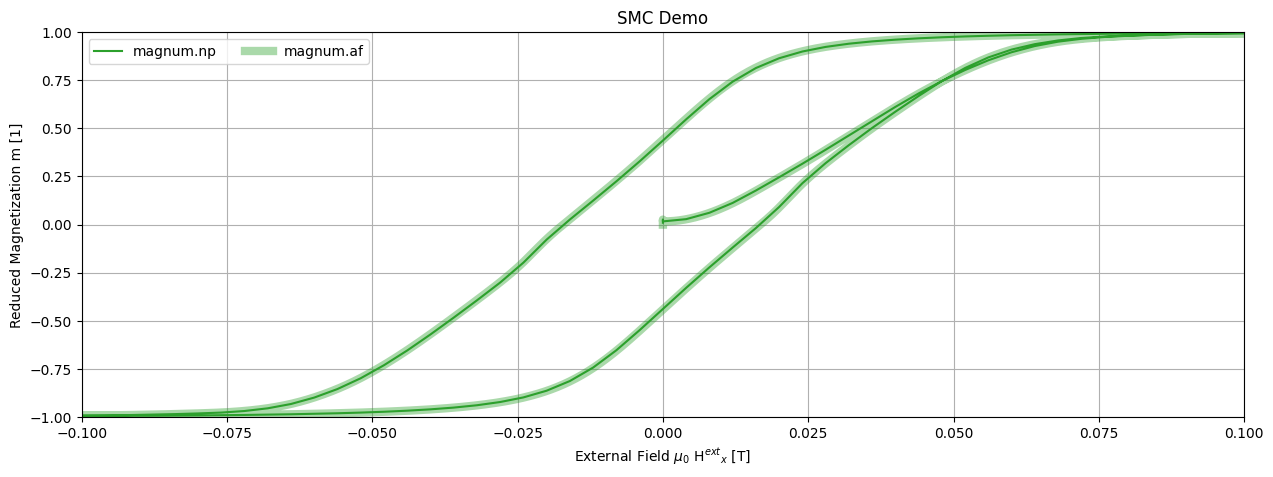

In [3]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("data/m.dat")
ref = np.loadtxt("ref/m_ref.dat")

fig, ax = plt.subplots(figsize=(15,5))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax.plot(data[:,1]*4*np.pi*1e-7, data[:,4], '-', color = cycle[2], label = "magnum.np")
ax.plot(ref[:,1]*4*np.pi*1e-7, ref[:,4], '-', color = cycle[2], linewidth = 6, alpha = 0.4, label = "magnum.af")

ax.set_xlim([-0.1,0.1])
ax.set_ylim([-1,1])
ax.set_title("SMC Demo")
ax.set_xlabel("External Field $\mu$$_0$ H$^{ext}$$_x$ [T]")
ax.set_ylabel("Reduced Magnetization m [1]")
ax.legend(ncol=3)
ax.grid()
fig.savefig("data/results.png")